Enveloping distribution sampling method was first proposed by Christ and van Gunsteren in 2007.\cite{ChristJCP2007}
When calculating the free energy difference between states $A$ and $B$,
\begin{equation}
	\Delta G_{BA}=G_B-G_A=-\beta^{-1}\ln{\frac{Q_B}{Q_A}},
\end{equation}
we may encounter convergence difficulty if the important spaces of these two states are well separated, shown as black lines in the next Figure.
Simulation under the Hamiltonian of state $A$ can hardly cover the important region of Hamiltonian $B$, and then the free energy of state $B$ will be significantly overestimated.A simple solution to this difficulty is "overlap sampling", in which a reference state that can cover the important regions of both Hamiltonians $A$ and $B$ is introduced.We then carry out a simulation for the reference state and the free energy difference between state $A$ and $B$ can be calculated as
\begin{equation}
	\Delta G_{BA}=\Delta G_{BR}-\Delta G_{AR}=-\beta^{-1}\ln{\frac{\left<e^{-\beta\left(H_B-H_R\right)}\right>_R}{\left<e^{-\beta\left(H_A-H_R\right)}\right>_R}},
\end{equation} 
which is a combination of two thermodynamic perturbation calculations from the reference state to the target states.

However, building the Hamiltonian of the reference state is not trivial. Without knowledge of the Hamiltonians for state $A$ and state $B$, we cannot generate an effective Hamiltonian,especially in a high dimensional space. Enveloping distribution sampling method provides a natural way to generate the Hamiltonian for the reference state with simply mixing the Hamiltonians of state $A$ and state $B$ in the following way
\begin{equation}
	H_R(\mathbf{r})=-\left(s\beta\right)^{-1}\ln{\left(e^{-s\beta H_A(\mathbf{r})}+e^{-s\beta H_B(\mathbf{r})}\right)},
    \label{eq:H_R}
\end{equation}
where $s$ is a scale factor that modulates the mixing as shown in the next figure. Increasing $s$ lows the barrier height separating the two minima in the mixed potential, thereby enhances the transition. Straightforwardly, you may come to the idea that running Hamiltonian-REMD with different $s$ can remarkably increase the efficiency.
If you take a close look at Eq. \ref{eq:H_R}, you will find that $s$ appears always with $\beta$. In other words, changing $s$ is equivalent to changing the temperature for the simulation. This is one interesting case where H-REMD and T-REMD are coincident with each other. 
The force is also a mixing quantity from two Hamiltonians as
\begin{align}
	\mathbf{F}_R^i=-\frac{\partial H_R}{\partial \mathbf{r}^i}=&\frac{e^{-s\beta H_A(\mathbf{r})}}{e^{-s\beta H_A(\mathbf{r})}+e^{-s\beta H_B(\mathbf{r})}}\left(-\frac{\partial H_A(\mathbf{r})}{\partial \mathbf{r}^i}\right)\notag\\
	&+\frac{e^{-s\beta H_B(\mathbf{r})}}{e^{-s\beta H_A(\mathbf{r})}+e^{-s\beta H_B(\mathbf{r})}}\left(-\frac{\partial H_B(\mathbf{r})}{\partial \mathbf{r}^i}\right).
\end{align}

In this script, we are going to calculate the free energy difference between two states.
State 0 has a Hamiltonian $H_0=(x+2.0)^2$ in one-dimensional space, and state 1 has a Hamiltonian $H_1=1+0.25*(x-2.0)^2$. The free energy difference between these two states is
\begin{align*}
\Delta A&=\ln{\frac{\int \exp{(-H_0(\mathbf{x}))}d\mathbf{x}}{\int \exp{(-H_1(\mathbf{x}))}d\mathbf{x}}}\\
     &=\ln{\frac{\int \exp{(-(x+2.0)^2)}d\mathbf{x}}{\int \exp{(-1-0.25*(x-2.0)^2)}d\mathbf{x}}}\\
     &=\ln{\frac{\sqrt{2\pi*0.5}}{\exp{(-1)}\sqrt{2\pi*2}}}\\
     &=0.31
\end{align*}

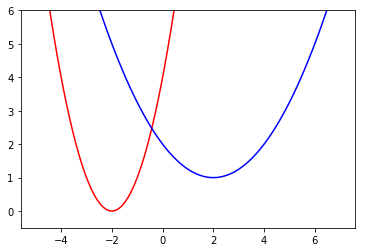

In [1]:
from math import *
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
np.set_printoptions(precision=3)
def u0(x):
    return (x+2)**2
def u1(x):
    return 1.0+0.25*(x-2)**2
x=np.linspace(-5,7,100)
y0=u0(x)
y1=u1(x)
plt.ylim(-0.5, 6)
plt.plot(x,y0,'r',x,y1,'b')
plt.show()

## In the first step, we will apply a direct TP calculation using the Equation shown above. 
Taking the explicit expressions for $H_0$ and $H_1$ in the equation above, we have
\begin{equation}
\Delta A=-\ln \left<e^{-\left[2+0.25\times(x-2)^2-(x+2)^2\right]}\right>_0
\end{equation}

Now we define a Monte Carlo (MC) propagator for this simulation. 
In the MC simulation, the transition between states must satisfy the detailed balance, i.e.
$$\rho(x_i)P(x_i,x_j)=\rho(x_j)P(x_j,x_i),$$
where $\rho(x_i)$ and $P(x_i,x_j)$ are the probability of the microstate $x_i$ and the transition probability from $x_i$ to $x_j$, 
respectively.
Suppose at $t_0$ the system is located at microstate $x_0$ with energy u(x_0). We make a random trial move to $x_1^t$ with energy 
$u(x_1^t)$.

if $u(x_1^t)<u(x_1^t)$

  {
  $x_1=x_1^t$
  }
  
else

  {
   generate a random number s evenly distributed in [0,1]
  
   if $s<e^{-[u(x_1^t)-u(x_1^t)]}$
  
   {
    $x_1=x_1^t$
    }
    
   else
  
   {
    $x_1=x_0$
   }
  }

In [2]:
def MCpropagator(x0,dx,N,dN,u):
    count = 0
    x = np.empty(N)
    xcurrent = x0
    while count <N:
        innercount = 0
        while innercount < dN:
            rnd = np.random.uniform(0.0,1.0)
            if rnd < 0.5:
                xtrial = xcurrent - dx
            else:
                xtrial = xcurrent + dx

            deltau = u(xtrial) - u(xcurrent)
            if deltau < 0.0:
                xcurrent = xtrial
            else:
                acceptanceratio = np.exp(-deltau)
                if acceptanceratio > np.random.uniform(0.0,1.0):
                    xcurrent = xtrial
                else:
                    xcurrent = xcurrent
            innercount = innercount + 1
        x[count]=xcurrent
        count = count + 1
    return x, count

Number of samples generated:   10000
The distribution of the samples looks like:


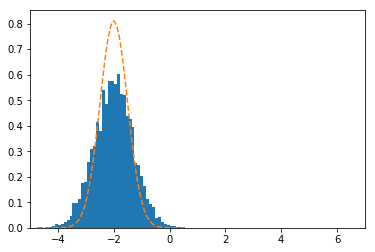

In [3]:
dx = 0.01
N = 10000
dN = 1600
x0 = -1.5
x = np.empty(N)
x, count = MCpropagator(x0,dx,N,dN,u0)
print('Number of samples generated:%8d' %count)
print('The distribution of the samples looks like:')
prob, bins, patches = plt.hist(x, bins=50, normed=True)
mean = np.mean(x)
variance = np.var(x)
npdf = mlab.normpdf(bins,mean,variance)
plt.plot(bins, npdf, '--')
plt.xlim(-5,7)
plt.show()

With these microstates sampled under $H_0$, we calculate the free energy difference.

In [4]:
def TP(x,u1,u0):
    edu = np.zeros(x.size)
    edu = np.exp(-(u1(x)-u0(x)))
    S = np.mean(edu)
    varS = np.var(edu)/x.size
    deltaA = -np.log(S)
    varA = varS/S**2
    return deltaA, varA

In [5]:
deltaA_direct, varA_direct = TP(x,u1,u0)
print('The free energy difference from a direct TP calculation is %8.2f +- %5.2f' % (deltaA_direct, sqrt(varA_direct)))

The free energy difference from a direct TP calculation is     2.05 +-  0.17


As you can see, the free energy differece from this direct TP calculation deviates from the true answer (1.31).
In the following, we will use enveloping distribution sampling to enhance the samping in the overlap region. In this method, we first introduce a sampling Hamiltonian $H_R$ with a tunable parameter $s$ defined in Eq. \ref{eq:H_R}.

In [6]:
def uR(s,u0,u1,x):
    return -s**(-1)*np.log((np.exp(-s*u0(x))+np.exp(-s*u1(x))))

We can plot the potential energy surfaces


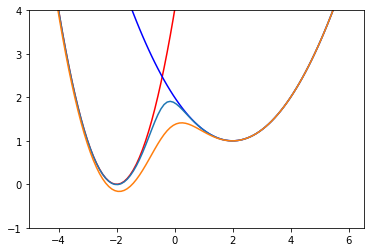

In [7]:
x=np.linspace(-4.5,6.0,100,dtype=np.float64)
y0=u0(x)
y1=u1(x)
ys1=uR(1,u0,u1,x)
ys2=uR(0.5,u0,u1,x)
plt.ylim(-1, 4)
plt.plot(x,y0,'r')
plt.plot(x,y1,'b')
plt.plot(x,ys1)
plt.plot(x,ys2)
plt.show()

It shows that $s=0.5$ can significantly reduce the energy barrier. Therefore, we will run a simulation on $H_R(s=0.4)$, and then calculate the free energy difference between $H_0$ and $H_R$, and that between $H_1$ and $H_R$.

In [8]:
def MCpropagator2(x0,dx,N,dN,uR,u0,u1,s):
    count = 0
    x = np.empty(N)
    xcurrent = x0
    while count < N:
        innercount = 0
        while innercount < dN:
            rnd = np.random.uniform(0.,1.)
            if rnd<0.5:
                xtrial = xcurrent - dx
            else:
                xtrial = xcurrent + dx

            deltau = uR(s,u0,u1,xtrial) - uR(s,u0,u1,xcurrent)
            if deltau < 0:
                xcurrent = xtrial
            else:
                acceptanceratio = np.exp(-deltau)
                if acceptanceratio > np.random.uniform(0.0,1.0):
                    xcurrent = xtrial
                else:
                    xcurrent = xcurrent
            innercount = innercount + 1
        x[count] = xcurrent
        count = count + 1
    return x, count

def TP2(x,u,uR,u0,u1,s):
    edu=np.zeros(x.size)
    edu = np.exp(-(u(x)-uR(s,u0,u1,x)))
    S = np.mean(edu)
    varS = np.var(edu)/x.size
    deltaA = -np.log(S)
    varA = varS/S**2
    return deltaA, varA

The free energy difference between U_0 to U_R is     0.68 +-  0.01
The free energy difference between U_1 to U_R is     1.08 +-  0.01

The total free energy difference is     0.41 +-  0.02


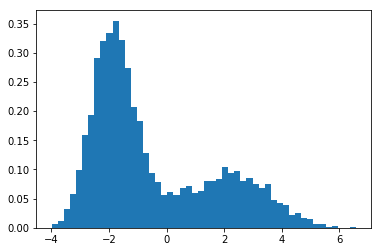

In [9]:
dx = 0.01
N = 10000
dN = 1600
x0 = -1.5
x = np.empty(N)
s = 0.5
x, count = MCpropagator2(x0,dx,N,dN,uR,u0,u1,s)
prob, bins, patches = plt.hist(x, bins=50, normed=True)
mean = np.mean(x)
variance = np.var(x)
deltaA0, varA0 = TP2(x,u0,uR,u0,u1,s)
print('The free energy difference between U_0 to U_R is %8.2f +- %5.2f' % (deltaA0, np.sqrt(varA0)))
deltaA1, varA1 = TP2(x,u1,uR,u0,u1,s)
print('The free energy difference between U_1 to U_R is %8.2f +- %5.2f' % (deltaA1, np.sqrt(varA1)))
print('')
print('The total free energy difference is %8.2f +- %5.2f' %(deltaA1-deltaA0,np.sqrt(varA0+varA1)))
plt.show()

Next, we will make some modifications to this method by 
\begin{equation}
	H_R(\mathbf{r})=-\left(s\beta\right)^{-1}\ln{\left(e^{-s\beta \left[H_A(\mathbf{r})-H_A^{min}\right]}+e^{-s\beta \left[H_B(\mathbf{r})-H_B^{min}\right]}\right)}.
\end{equation}


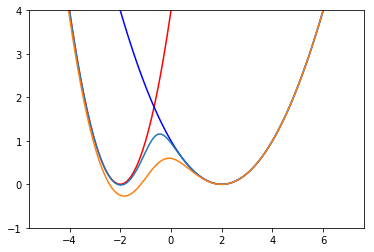

In [10]:
def u0shift(x):
    return (x+2)**2
def u1shift(x):
    return 0.25*(x-2)**2
x=np.linspace(-5,7,100)
y0=u0shift(x)
y1=u1shift(x)
ys1=uR(1,u0shift,u1shift,x)
ys2=uR(0.5,u0shift,u1shift,x)
plt.ylim(-1, 4)
plt.plot(x,y0,'r')
plt.plot(x,y1,'b')
plt.plot(x,ys1)
plt.plot(x,ys2)
plt.show()

It can be seen from this Figure that the energy barrier is lowered a little bit further than the original EDS. Practically, we can run two simulation under $H_0$ and $H_1$, respectively, and calculate the lowest energies for $H_0$ and $H_1$ out of these two trajectories.

The free energy difference between U_0 to U_R is     1.07 +-  0.01
The free energy difference between U_1 to U_R is     1.71 +-  0.01

The total free energy difference is     0.64 +-  0.01


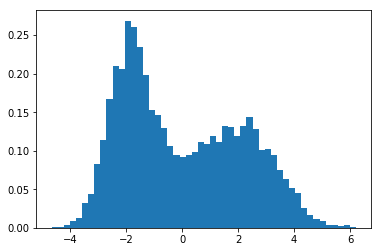

In [11]:
dx = 0.01
N = 10000
dN = 1600
x0 = -1.5
x = np.empty(N)
s = 0.5
x, count = MCpropagator2(x0,dx,N,dN,uR,u0shift,u1shift,s)
prob, bins, patches = plt.hist(x, bins=50, normed=True)
mean = np.mean(x)
variance = np.var(x)
deltaA0shift, varA0shift = TP2(x,u0,uR,u0shift,u1shift,s)
print('The free energy difference between U_0 to U_R is %8.2f +- %5.2f' % (deltaA0shift, np.sqrt(varA0shift)))
deltaA1shift, varA1shift = TP2(x,u1,uR,u0shift,u1shift,s)
print('The free energy difference between U_1 to U_R is %8.2f +- %5.2f' % (deltaA1shift, np.sqrt(varA1shift)))
print('')
print('The total free energy difference is %8.2f +- %5.2f' %(deltaA1shift-deltaA0shift,np.sqrt(varA0shift+varA1shift)))
plt.show()

# References

(<a id="cit-ChristJCP2007" href="#call-ChristJCP2007">Christ and van Gunsteren, 2007</a>) Christ Clara D. and van Gunsteren Wilfred F., ``_Enveloping Distribution Sampling: A Method to Calculate Free Energy Differences from a Single Simulation_'', J. Chem. Phys., vol. 126, number 18, pp. 184110,  2007.  [online](http://dx.doi.org/10.1063/1.2730508)

